In [1]:
%load_ext autoreload
%autoreload 2
import pyBigWig, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import shutil
import seaborn as sns
import numpy as np
import util
import itertools
import metrics
import yaml
import wandb
import tfr_evaluate
from tqdm import tqdm
from test_to_bw_fast import get_config
from tfr_evaluate import get_true_pred, change_resolution, collect_datasets, collect_run_dirs, get_performance

In [3]:
smoothen_results = pd.read_csv('smoothen_results_basenji.csv')

In [4]:
smoothen_results

,Unnamed: 0,raw bin size,smooth bin size,mse,js_per_seq,js_conc,poiss,pr_corr,sp_corr
0,0,1.0,1.0,0.700204,0.333073,0.366932,0.808290,0.576753,0.473844
1,0,1.0,32.0,0.681672,0.083806,0.126571,0.130059,0.582241,0.481771
2,0,1.0,64.0,0.660239,0.081216,0.124645,0.130146,0.586442,0.487214
3,0,1.0,128.0,0.609257,0.075657,0.120537,0.130967,0.594399,0.497320
4,0,1.0,256.0,0.508498,0.064762,0.112808,0.133759,0.607605,0.515620
5,0,1.0,512.0,0.387116,0.050808,0.103163,0.139274,0.619913,0.536297
6,0,1.0,1024.0,0.271726,0.036119,0.092599,0.147411,0.624910,0.549940
7,0,1.0,2048.0,0.175884,NaN,0.080853,0.156426,0.619849,0.555834
8,0,32.0,32.0,0.671617,0.319806,0.358716,0.807245,0.584464,0.481458
9,0,32.0,64.0,0.636158,0.079584,0.123234,0.129302,0.593798,0.491004


In [8]:
metric_label = {'pr_corr':'Pearson r'}
metric = list(metric_label.keys())[0]
label = metric_label[metric]

In [9]:
padded_values = []
bin_sizes = [1, 32, 64, 128, 256, 512, 1024, 2048]

for train_bin, df in smoothen_results.groupby('raw bin size'):
    pr_values = list(df[metric].values)
    add_N = len(bin_sizes)-len(pr_values)
    if add_N>0:
        pr_values = [np.nan for n in range(add_N)]+pr_values
    padded_values.append(pr_values)

Text(33.0, 0.5, 'Training bin size')

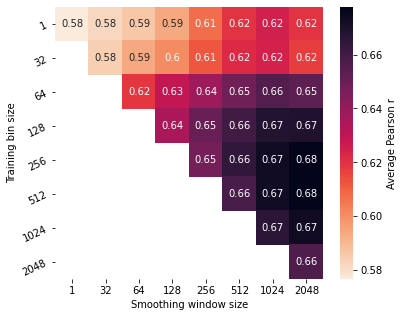

In [11]:
fig, ax = plt.subplots(figsize=[6, 5])
 
# creating mask
mask = np.triu(np.ones_like(padded_values), 1).T
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(padded_values, cmap="rocket_r", annot=True, mask=mask, 
                       cbar_kws={'label': "Average "+label}, ax=ax)
dataplot.set_xticks([r+0.5 for r in range(len(bin_sizes))]) 
dataplot.set_yticks([r+0.5 for r in range(len(bin_sizes))]) 
dataplot.set_xticklabels(bin_sizes) 
dataplot.set_yticklabels(bin_sizes, rotation=25) 
dataplot.set_xlabel('Smoothing window size')
dataplot.set_ylabel('Training bin size')